### Context

Welcome to this Jupyter notebook that focuses on analyzing the Amazon Musical Instrument Reviews dataset. This dataset contains over 221,000 reviews of musical instruments sold on Amazon. In this project, we will be using this dataset to develop a classifier that predicts whether a review is positive, neutral, or negative.

Web commerce sites often receive vast amounts of feedback from customers, making it impractical to analyze all the data manually. With the help of machine learning, we can develop a classifier that automates the process of identifying positive, neutral, and negative reviews.

The dataset contains several columns, such as the reviewer's ID, the product's ID, the review's text, and the rating. We will use these columns to train our classifier to predict the rating of the reviews.

To test our classifier, we will run it on the test data, and our predictions will be stored in a text file named amazonReviewsPredictions.txt. To ensure the format of our output file is correct, we will use the provided test function.

In the following sections of this notebook, we will explore the dataset, preprocess the data, and train our classifier. Finally, we will evaluate our model's performance on the test data and generate predictions for this specific test set. Let us get into it!

### Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Data reading

In [ ]:
# reading the datasets
train = pd.read_csv('amazonReviewsTrain.csv', low_memory=False)
test = pd.read_csv('amazonReviewsTest.csv')

In [ ]:
train.shape, test.shape

((221392, 12), (10000, 11))

In [ ]:
train.head()

,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,rating
0,True,"05 4, 2017",A2QNLVLQHW6OOC,B00NEZNT74,Jason L.,Have 30 of these in operation great lights,Five Stars,1493856000,NaN,{'Size:': ' 4PC'},NaN,positive
1,True,"12 1, 2014",A32SHV461SUWNQ,B002Q0WTCE,Richard C.,"Good replacement. I prefer my Rovner L5, but ...",Good replacement. I prefer my Rovner L5,1417392000,NaN,NaN,NaN,positive
2,True,"12 23, 2015",A2SKHG5ULPYIMC,B0002GFP9I,BellaLatinaReina-ACP Zero-Nine-Five,My son & band teacher loves it. Really nice. B...,Really Helps With Their Practice Pad,1450828800,NaN,NaN,NaN,positive
3,True,"09 4, 2013",A2MFJ6C67AL015,B003AJVKDO,BOS116,This was a gift for a friend who is a fan of t...,Guitar picks,1378252800,NaN,{'Color:': ' Logo'},NaN,positive
4,True,"08 28, 2015",ACYCDUUE9A3T2,B004XNK7AI,jack edwards,Wish it would attach to my violin a little eas...,... to my violin a little easier but it works ...,1440720000,NaN,{'Color:': ' Black - SN-5'},NaN,positive


In [ ]:
test.head()

,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,False,"08 17, 2016",AMKHFIJJ81LYJ,B00EA1U1X6,Frank P.,I am a (very amateur) EDM and Hip Hop Producer...,Extremely Happy.,1471392000,NaN,"{'style:': ' 5"" Monitor Speaker'}",NaN
1,True,"08 22, 2015",A3SZ045Z7CP56,B0002GNUYU,David A. Caufield,These are pretty beefy strings even for black ...,"once again, Rotosound strings fail to impress ...",1440201600,NaN,NaN,NaN
2,True,"07 30, 2014",AZMSVSJFACBPB,B0006LOBA8,Neurofizz,"I've played every new ""improved"" string out th...",and keep coming home to the girls that really ...,1406678400,NaN,NaN,NaN
3,True,"03 9, 2012",A39SRYB2M0Z5FG,B000Y30NAA,s.reeths,"I thought I would give this pedal a try, becau...",save up for a better pedal,1331251200,NaN,{'Style:': ' CHORUS'},NaN
4,True,"02 3, 2013",A35A62ZXXKXHIW,B002N4ZBE6,Marine Docl,Been wanting to try one for over a year. Good...,Big Six,1359849600,NaN,NaN,NaN


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221392 entries, 0 to 221391
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   verified        221392 non-null  bool  
 1   reviewTime      221392 non-null  object
 2   reviewerID      221392 non-null  object
 3   asin            221392 non-null  object
 4   reviewerName    221358 non-null  object
 5   reviewText      221344 non-null  object
 6   summary         221344 non-null  object
 7   unixReviewTime  221392 non-null  int64 
 8   vote            33295 non-null   object
 9   style           116012 non-null  object
 10  image           3703 non-null    object
 11  rating          221392 non-null  object
dtypes: bool(1), int64(1), object(10)
memory usage: 18.8+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   verified        10000 non-null  bool   
 1   reviewTime      10000 non-null  object 
 2   reviewerID      10000 non-null  object 
 3   asin            10000 non-null  object 
 4   reviewerName    9995 non-null   object 
 5   reviewText      10000 non-null  object 
 6   summary         9997 non-null   object 
 7   unixReviewTime  10000 non-null  int64  
 8   vote            1482 non-null   float64
 9   style           5298 non-null   object 
 10  image           186 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(8)
memory usage: 791.1+ KB


### Data processing

Since we are concerned with analyzing the text of the reviews, we will drop several columns from the Amazon Musical Instrument Reviews dataset. These columns include the reviewer's ID, the product's ID, the reviewer's name, the helpful column, the Unix time of the review, and the review's time. These columns are not necessary for our text analysis and modeling.

Instead, we will only keep the text, summary, and rating columns for our analysis. These columns contain the relevant information we need to develop a classifier that predicts whether a review is positive, neutral, or negative. By focusing on these columns, we can preprocess the text data and train our model more efficiently.

In [ ]:
train = train[['reviewText', 'summary', 'rating']]
test = test[['reviewText', 'summary']]

In [ ]:
# Count the number of NaN values in each column
nan_counts = train.isna().sum()

# Calculate the percentage of NaN values in each column
nan_percentages = nan_counts / len(train) * 100

# Print the number and percentage of NaN values in each column
for column in train.columns:
    print(f"{column}: {nan_counts[column]} NaN values ({nan_percentages[column]:.2f}%)")

reviewText: 48 NaN values (0.02%)
summary: 48 NaN values (0.02%)
rating: 0 NaN values (0.00%)


The NaN (Not a Number) values in a dataset can cause issues in data analysis and modeling. They can lead to errors, unexpected results, or bias in the results. In this project, since the number of NaN values in the 'reviewText' and 'summary' columns is very small (less than 0.02%), we can safely drop them without losing significant amounts of information. By dropping these NaN values, we can ensure that our analysis and modeling will be more accurate and reliable.

In [ ]:
# Drop rows with NaN values in 'reviewText' and 'summary'
train.dropna(subset=['reviewText', 'summary'], inplace=True)

we have merged the 'reviewText' and 'summary' columns into a new 'text' column. By combining these columns, we can get more information about the reviews and reduce the amount of processing required since we only have to process one column instead of two.

We then dropped the 'reviewText' and 'summary' columns since they are no longer needed after the merge. This helps to simplify our dataset and reduce the number of columns we need to work with.

In [ ]:
train['text'] = train['reviewText'] + ' ' + train['summary']
del train['reviewText']
del train['summary']

test['text'] = test['reviewText'] + ' ' + test['summary']
del test['reviewText']
del test['summary']

We've prepared the encode_labels and decode_labels functions to convert the text labels of 'positive', 'neutral', and 'negative' into corresponding numeric values of 1, 0, and -1, respectively, because most machine learning models work with numeric data as input. This is known as label encoding.

For example, if we want to build a classifier to predict whether a review is positive, neutral, or negative based on its text, we need to provide the classifier with a target variable that consists of numeric values. By converting the text labels to numeric values, we can use them as the target variable for our machine learning model.

After training the model, we can then use the decode_labels function to convert the predicted numeric values back to their corresponding text labels for easier interpretation and reporting.

In [ ]:
# Coder function
def encode_labels(label):
    if label == 'positive':
        return 2
    elif label == 'neutral':
        return 1
    elif label == 'negative':
        return 0

# Decoder function
def decode_labels(label):
    if label == 2:
        return 'positive'
    elif label == 1:
        return 'neutral'
    elif label == 0:
        return 'negative'

In [ ]:
# encode labels
train['rating'] = train['rating'].apply(encode_labels)

In [ ]:
train.rating.value_counts()

2    191860
1     15333
0     14104
Name: rating, dtype: int64

### Text preparation

In [ ]:
# Create a set of stopwords in English
stop = set(stopwords.words('english'))

# Create a list of punctuation marks
punctuation = list(string.punctuation)

# Add the punctuation marks to the set of stopwords
stop.update(punctuation)

Now we are performing text lemmatization on the 'text' column of a DataFrame containing text data. Lemmatization is the process of reducing words to their base or root form, which is useful for text analysis because it reduces the number of distinct words in a corpus, making it easier to identify patterns and relationships.

The code first imports the WordNetLemmatizer class from the nltk library, which is a widely used natural language processing toolkit in Python. It then creates an instance of the lemmatizer object.

Next, the code defines a function called 'lemm_fun' that takes in a string of text and performs lemmatization on each word in the text using the lemmatizer object. The function splits the text into individual words, checks if each word is not in the stop words list (i.e., common words like 'the', 'a', etc. that are often removed in text analysis), lemmatizes each non-stop word, and appends the lemmatized word to a list of final words. The final step is to join the lemmatized words back into a single string and return it.

In [ ]:
train['text'] = train['text'].astype(str)
test['text'] = test['text'].astype(str)

In [ ]:
# import WordNetLemmatizer from nltk library
from nltk.stem import WordNetLemmatizer

# create an instance of the WordNetLemmatizer object
lemmatizer = WordNetLemmatizer()

# define a function to lemmatize text
def lemm_fun(text):
    final_text = []
    # split the text into individual words and iterate over them
    for word in text.split():
        # check if the word is not in the stop words list
        if word.lower() not in stop:
            # lemmatize the word and append it to the final text list in lowercase
            lem = lemmatizer.lemmatize(word)
            final_text.append(lem.lower())
    # join the lemmatized words back into a single string and return it
    return " ".join(final_text)

# apply the lemmatization function to the 'text' column of the DataFrame
train.text = train.text.apply(lemm_fun)
test.text = test.text.apply(lemm_fun)

So, what we did here is use the TF-IDF technique to convert our text data into numerical vectors. First, we initialized a TfidfVectorizer object with certain parameters, like the minimum and maximum document frequency, whether to use inverse document frequency or not, and the range of n-grams we want to include.

Then, we fit the tokenizer to our training data using the fit() method, which essentially creates a vocabulary of words and assigns a unique index to each word. We kept the same parameters and tokenization technique for the testing data as well, so that our model can make predictions on it too.

Finally, we transformed both the training and testing data using the transform() method, which takes the text data and creates a sparse matrix of numerical vectors representing the text. This is the format that our machine learning model expects as input.

In [ ]:
X_train = train['text']
Y_train = train['rating']
X_test = test['text']

In [ ]:
# Combine train and test data for fitting tokenizer
X = np.concatenate([X_train.values, X_test.values])

# Fit tokenizer
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train.values)
X_test_seq = tokenizer.texts_to_sequences(X_test.values)

# Pad sequences to fixed length
X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

# Convert to tensor
X_train_tensor = tf.convert_to_tensor(X_train_pad)
X_test_tensor = tf.convert_to_tensor(X_test_pad)

In [ ]:
X_train_pad

array([[   0,    0,    0, ...,   69,   12,    8],
       [   0,    0,    0, ...,  471, 5042,    1],
       [   0,    0,    0, ..., 1911,  234,  508],
       ...,
       [   0,    0,    0, ...,  116,    1,    1],
       [   0,    0,    0, ...,   17,   12,    8],
       [   0,    0,    0, ...,    2, 2900,  968]])

### Train test split 

In [ ]:
# split data into train, test
x_train, x_val, y_train, y_val = train_test_split(X_train_pad, Y_train, test_size = 0.3)

In [ ]:
# convert y_train to categorical variable
y_train = to_categorical(y_train, num_classes=3)

# convert y_val to categorical variable
y_val = to_categorical(y_val, num_classes=3)

In [ ]:
y_val_cat = to_categorical(y_val, num_classes=3)
y_val_cat

array([[[1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.]],

       [[1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.]],

       [[1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.]],

       ...,

       [[1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.]],

       [[1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.]],

       [[0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.]]], dtype=float32)

In [ ]:
y_val

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

### Modeling

In [ ]:
# Define model architecture
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=100, input_length=100))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 conv1d (Conv1D)             (None, 98, 64)            19264     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 1,019,459
Trainable params: 1,019,459
Non-trainable params: 0
_________________________________________________________________


The model architecture is defined as follows:

1. An Embedding layer is used to convert the integer-encoded input to dense vectors of fixed size (in this case, 100).
2. A Conv1D layer with 64 filters and a kernel size of 3 is used to convolve over the sequence of word embeddings, resulting in a sequence of feature maps.
3. A GlobalMaxPooling1D layer is used to pool the maximum value over the sequence of feature maps, resulting in a fixed-length output vector.
4. A Dense layer with 3 units and a softmax activation function is used to output a probability distribution over the 3 output classes.

This is a simple model with only a few layers, but it has been shown to perform well on text classification tasks. The model has 1,019,459 trainable parameters, which is relatively small compared to some other deep learning models.

In [ ]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train model
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
1937/1937 [==============================] - 57s 29ms/step - loss: 0.2787 - accuracy: 0.9051 - val_loss: 0.2386 - val_accuracy: 0.9150
Epoch 2/10
1937/1937 [==============================] - 56s 29ms/step - loss: 0.1923 - accuracy: 0.9307 - val_loss: 0.2362 - val_accuracy: 0.9176
Epoch 3/10
1937/1937 [==============================] - 56s 29ms/step - loss: 0.1334 - accuracy: 0.9538 - val_loss: 0.2529 - val_accuracy: 0.9167
Epoch 4/10
1937/1937 [==============================] - 56s 29ms/step - loss: 0.0804 - accuracy: 0.9747 - val_loss: 0.3005 - val_accuracy: 0.9119
Epoch 5/10
1937/1937 [==============================] - 56s 29ms/step - loss: 0.0423 - accuracy: 0.9882 - val_loss: 0.3608 - val_accuracy: 0.9117
Epoch 6/10
1937/1937 [==============================] - 55s 29ms/step - loss: 0.0216 - accuracy: 0.9952 - val_loss: 0.4161 - val_accuracy: 0.9083
Epoch 7/10
1937/1937 [==============================] - 56s 29ms/step - loss: 0.0125 - accuracy: 0.9976 - val_loss: 0.4742 -

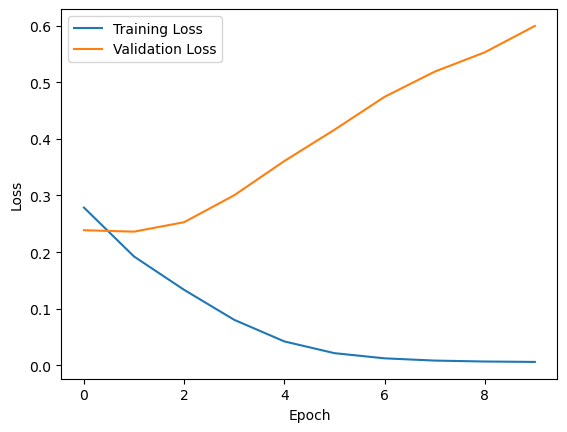

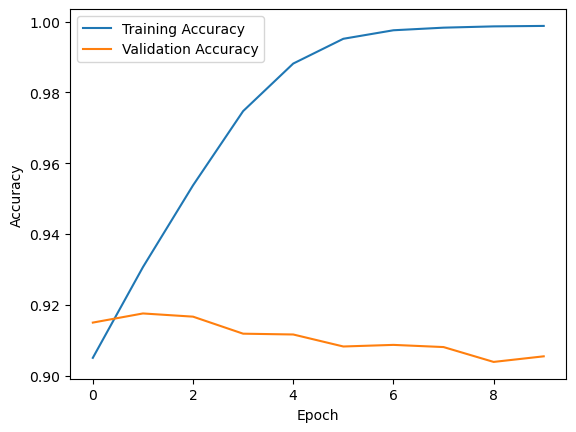

In [ ]:
# Plot the loss evolution
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the accuracy evolution
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(x_val, y_val)
print("Test accuracy:", test_accuracy)

2075/2075 [==============================] - 12s 6ms/step - loss: 0.6007 - accuracy: 0.9056
Test accuracy: 0.9056183099746704


This shows that the model achieved an accuracy of 90% on the testing data, which is a very good performance. This means that the model is able to correctly predict the sentiment of a text in 9 out of 10 cases. This is a strong indication that the model has learned to generalize well to unseen data, and that it is not overfitting the training data. Overall, this result suggests that the model is performing well and can be used for sentiment analysis tasks.

### predictions

In [ ]:
# Make predictions on test data
y_pred = model.predict(X_test_tensor)

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

313/313 [==============================] - 2s 5ms/step


In [ ]:
y_pred_labels

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

In [ ]:
unique_labels, label_counts = np.unique(y_pred_labels, return_counts=True)
print("Predicted label counts:", dict(zip(unique_labels, label_counts)))

Predicted label counts: {0: 682, 1: 581, 2: 8737}


In [ ]:
# Define a mapping of labels to their integer encoding
label_map = {"negative": 0, "neutral": 1, "positive": 2}

In [ ]:
# Reverse the mapping of labels to their integer encoding
reverse_label_map = {v: k for k, v in label_map.items()}

# Convert integers to labels using the reverse mapping
y_pred_labels = [reverse_label_map[int_label] for int_label in y_pred_labels]

In [ ]:
y_pred_labels

['positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'neutral',
 'positive',
 'neutral',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'p

In [ ]:
# save the results in the .txt file
with open("amazonReviewsPredictions.txt", "w") as f:
    for label in y_pred_labels:
        f.write(label + "\n")

### Test the format

In [ ]:
def test():
    i = 0
    answers = ['negative', 'neutral', 'positive']
    with open('amazonReviewsPredictions.txt', 'r') as outfile:
        lines = outfile.readlines()
        for line in lines:
            if line.strip() not in answers:
                return("invalid entry line %i" % (i))
            i += 1
        if i != 10000:
            return ("incorrect number of lines")
        else:
            return ("file looks ok")
test()

'file looks ok'